# Multilabel Classification of Satellite Imagery

## Overview
This study focussed on the development and evaluation of a standard Convolutional Neural Network (CNN) to automate multilabel classification of satellite image patches into one or more land cover types. The study utilised the dataset published for ['Planet: Understanding the Amazon from Space'](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) competition held on Kaggle in 2017 - now recognised by the community as a standard computer vision benchmark. The competition involved classifying 256x256 pixel patches of RGB composite Planet satellite imagery (1m spatial resolution) acquired over the Amazon rainforest in Brazil in terms of 17 land cover classes. An interview with competition winner who achieved a public leaderboard F-beta score of 0.93398 on 66% of the test dataset and a private leaderboard F-beta score of 0.93317 on 34% of the test dataset may be found [here](https://medium.com/kaggle-blog/planet-understanding-the-amazon-from-space-1st-place-winners-interview-bf66fb444bc2).

![Kaggle-Planet](https://storage.googleapis.com/kaggle-competitions/kaggle/6322/logos/header.png)

## Method
The Planet dataset provides a good example of a typical imbalanced classification problem where distribution of examples across known classes is biased or skewed. Without addressing this issue, randomly selected mini-batches will primarily consist of samples taken from majority classes - if the batch size is too small, minimal information from minority classes will be incorporated into gradient calculation / weight optimisation during training. A common symptom of imbalance problem is achieving 'high predictive accuracy' during training - then to discover during evaluation that model only correctly recognises one or more majority classes. 

This study utilised a basic form of [random stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) to ensure an even distribution of examples are selected across all land cover classes during training. For each land cover class, a list of images - and their corresponding pathnames - were encoded into a dataframe. The collection of 17 dataframes was subsequently passed as input argument into customised implementation of Keras data generator with image augmentation capabilities. Minibatches were assembled by randomly picking a land cover class id (0-16) and then choosing a random example from underlying  image list for subsequent augmentation.  

In [1]:
# authentication key
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='C:/Users/Chris.Williams/.gcs/arkham-255409-c59a52d8653f.json'

In [2]:
# define repo name and get root working directory
repo = 'planet'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\planet'

In [3]:
# add repo source directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )

In [4]:
# land cover labels
labels = [  'agriculture', 
            'artisinal_mine', 
            'bare_ground', 
            'blooming', 
            'blow_down', 
            'clear', 
            'cloudy', 
            'conventional_mine', 
            'cultivation', 
            'habitation', 
            'haze', 
            'partly_cloudy', 
            'primary', 
            'road', 
            'selective_logging', 
            'slash_burn', 
            'water' ]

# zip labels into dict with class id
classes = dict(zip( labels,range (len(labels) ) ) )

In [5]:
from google.cloud import storage
from io import BytesIO

# download pretrained model from google cloud
client = storage.Client()
bucket = client.get_bucket('eo-ald-update')

# construct remote path
repo = 'planet'
filenames = [ 'models/vgg16-256-128.zip', 'data/subset-1.zip' ]

# check files exist
for f in filenames:

    pathname = os.path.join( os.getcwd(), f )
    if not os.path.exists( pathname ):
                
        # make sub-directory if required
        if not os.path.exists ( os.path.dirname( pathname ) ):
            os.makedirs( os.path.dirname( pathname ) )

        # download blob
        remote_url = '{}/{}'.format( repo, f )

        blob = storage.blob.Blob( remote_url, bucket)
        with open( pathname, 'w+b' ) as z:
            blob.download_to_file( z )

In [6]:
from zipfile import ZipFile

# extract downloaded zip files 
for f in filenames:
    pathname = os.path.join( os.getcwd(), f )
#    with ZipFile( pathname, 'r') as zipObj:
       # extract contents to current directory
#       zipObj.extractall( os.path.dirname( pathname ) )

In [7]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def getSubset( pathname ):

    # get test dataframe
    df = pd.read_csv( pathname )

    # convert tags to tuple - add full image pathname
    df[ 'pathname' ] = df.image_name.apply( lambda x: os.path.join( 'data/subset-1/train', x + '.jpg' ) )
    df[ 'tags' ] = df.tags.apply(lambda x: tuple( x.split(' ') ) )

    # create and fit multilabel binariser
    mlb = MultiLabelBinarizer( list ( labels ) )
    df[ 'target' ] = tuple( mlb.fit_transform( df['tags'] ) )

    return df

In [8]:
# read csv files and get sample counts
samples = { 'train' : [], 'test' : [] }
for subset in [ 'train', 'test' ]:
    
    # load catalog file into dataframe
    df = getSubset( 'data/subset-1/{}.csv'.format( subset ) )
    for label in labels:
        samples[ subset ].append( sum( df[ 'tags' ].apply( lambda x: label in x ) ) )

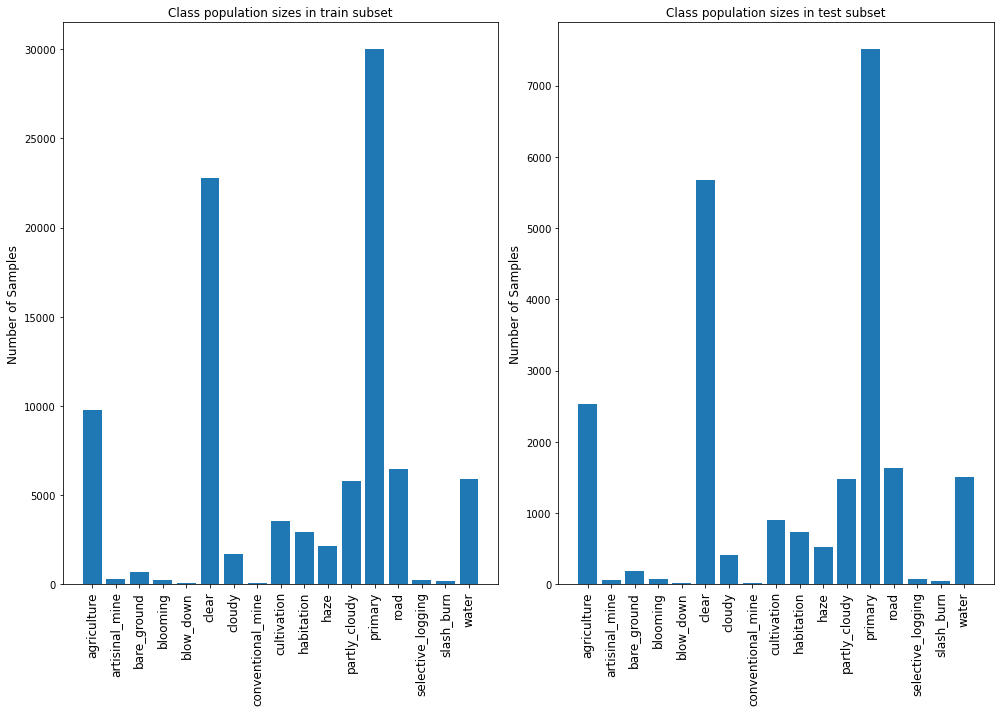

In [9]:
# create figure
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))
for idx, subset in enumerate ( [ 'train', 'test' ] ):

    # plot bars and tick labels
    axes[ idx ].set_title( 'Class population sizes in {} subset'.format( subset ))
    axes[ idx ].bar( labels, samples[ subset ] )
    axes[ idx ].set_ylabel( 'Number of Samples', fontsize=12 )
    axes[ idx ].set_xticklabels( labels, rotation='vertical', fontsize=12 )

# show
plt.tight_layout()
plt.show()
    

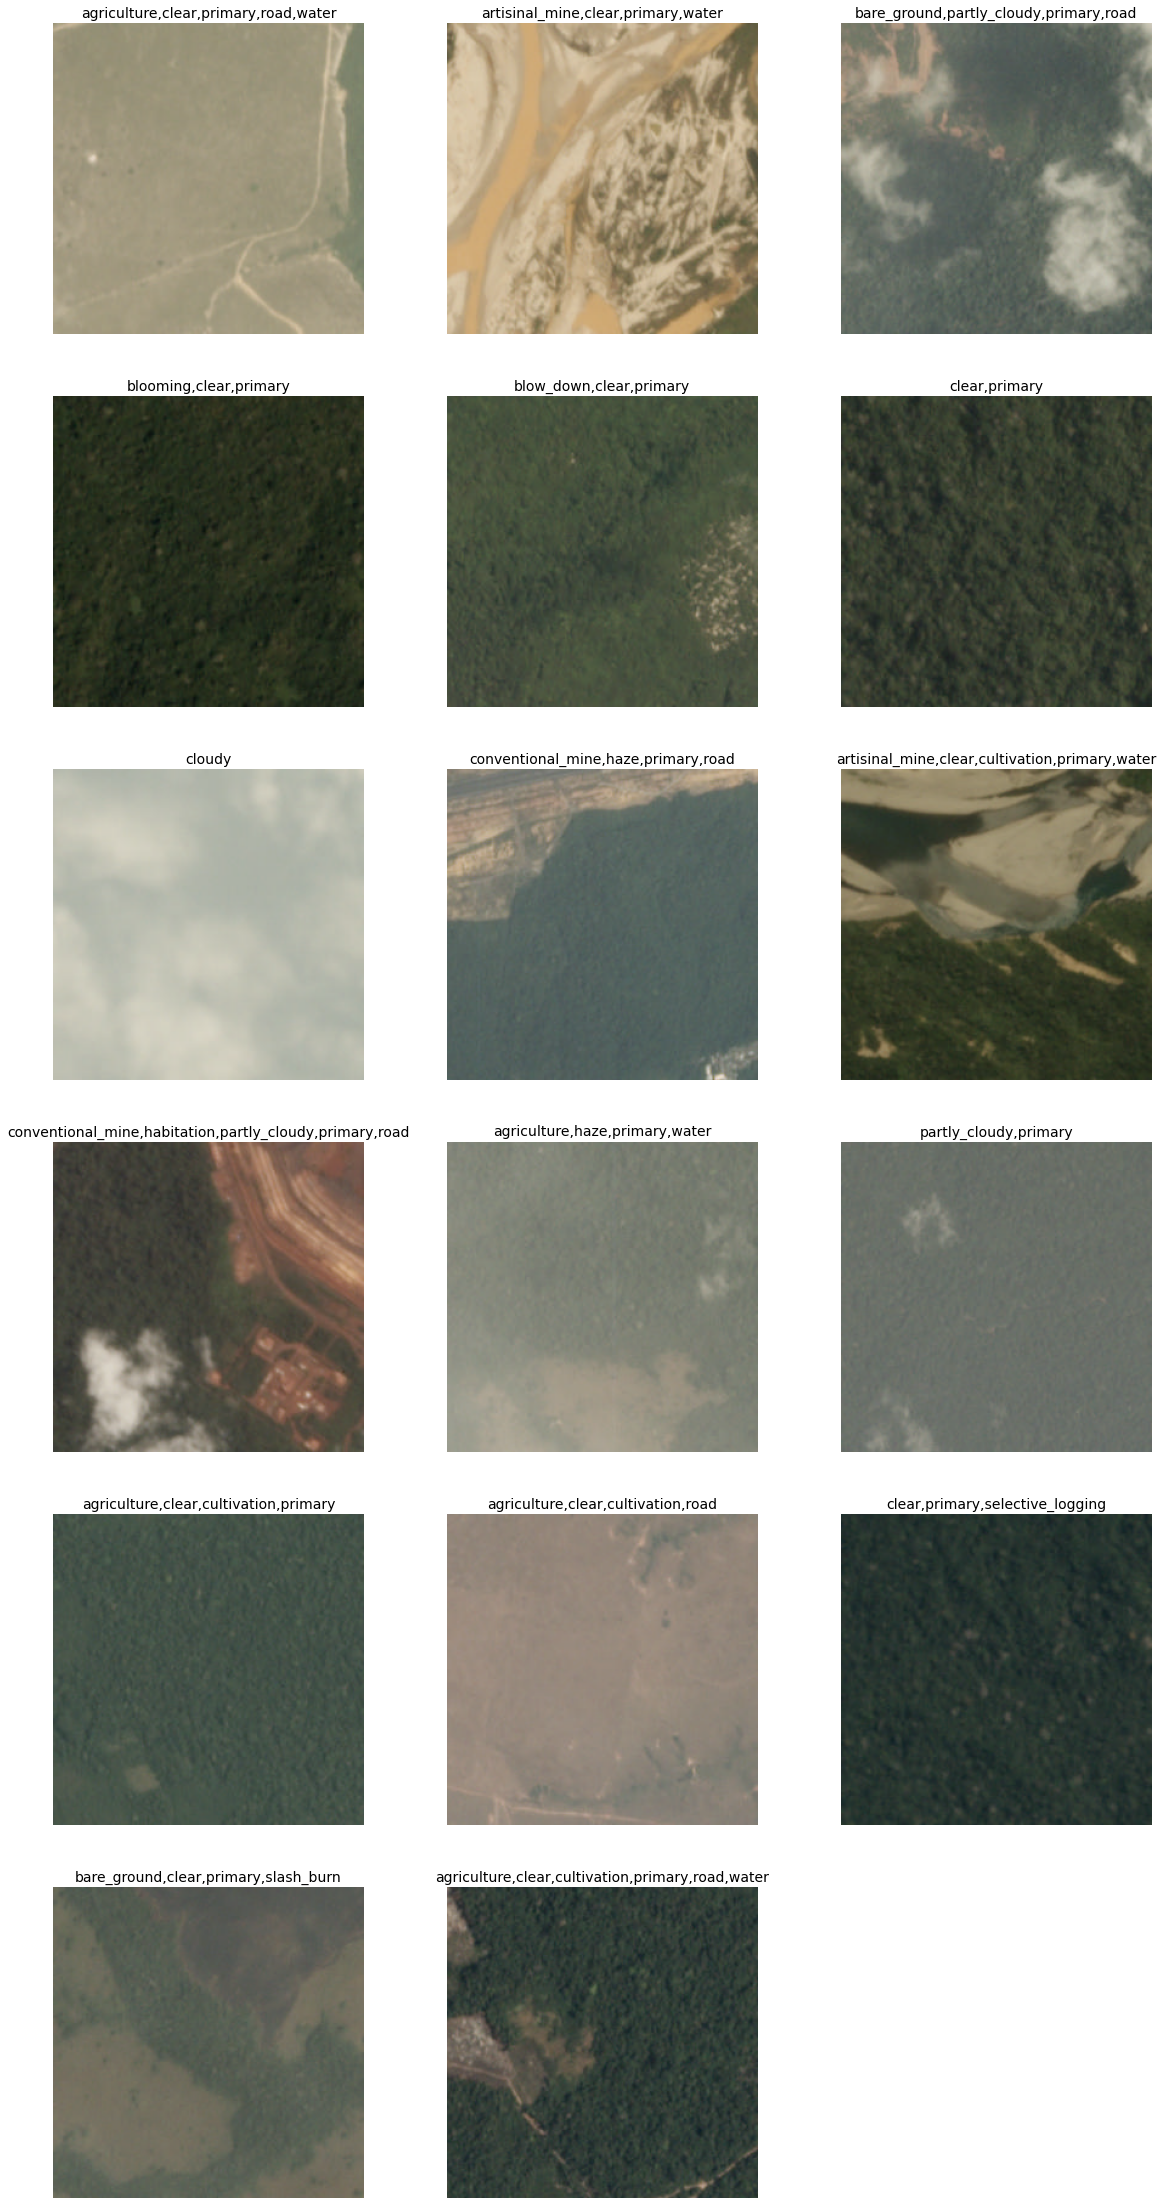

In [10]:
# show some images
nrows=6; ncols=3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))
axes[ 5 ][ 2 ].set_visible(False)

# iterate through classes / confusion matrices
row = 0; col = 0
for label in labels:

    # pick random sample from each class population
    subset = df[ df[ 'tags' ].apply( lambda x: label in x ) ]
    sample = subset.sample() 
    
    image = plt.imread( sample.iloc[ 0 ][ 'pathname' ] )
    axes[ row ][ col ].imshow( image )
    axes[ row ][ col ].set_axis_off()
    axes[ row ][ col ].set_title( ','.join( list( sample.iloc[0]['tags'] ) ), fontsize=14 )

    # update axes indices
    col += 1
    if col == ncols:
        col = 0; row += 1

## Model
Due to limited time and hardware resource, the study only focussed on evaluating performance of a standard VGG-16-based CNN backbone for image feature extraction - preloaded with ImageNet weights. The topmost layer of VGG16 CNN was attached to two fully connected 'Relu'-layers comprising 256 and 128 units respectively with dropout for regularization. The output layer comprised 17 units with sigmoid activation function to implement the multilabel classification - sigmoid values above 0.5 were assumed to represent high confidence prediction of underlying class.

![architecture](https://raw.githubusercontent.com/chris010970/planet/master/notebooks/assets/architecture.png)

## Results

In [11]:
# load model
from model import loadFromFile
model, architecture = loadFromFile( 'models/vgg16-256-128' )

Using TensorFlow backend.
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtype






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Loaded model from disk: models/vgg16-256-128


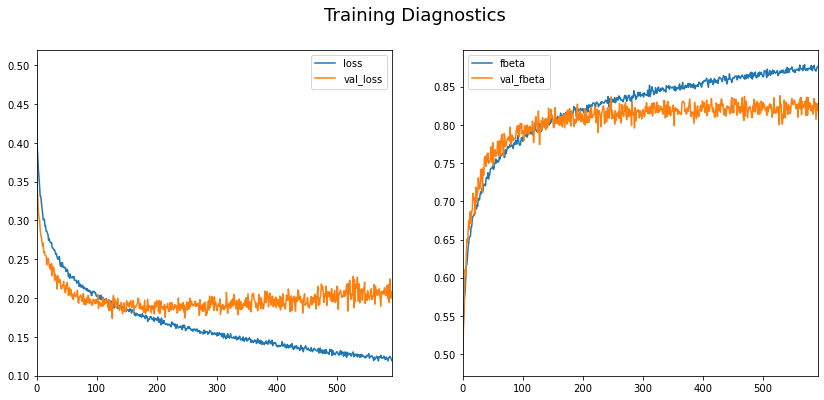

In [12]:
# load class-specific diagnostics from csv file
log = pd.read_csv( 'models/vgg16-256-128/log.csv' )
names = [ 'loss', 'fbeta' ]

# create figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle('Training Diagnostics', fontsize=18)

for idx, name in enumerate( names ):
    
    # plot diagnostics of model 
    log.plot.line( ax=axes[idx], y=[ name ] )
    log.plot.line( ax=axes[idx], y=[ 'val_'+ name ] )

In [13]:
# get imagenet stats for image normalisation
stats = pd.DataFrame ( { 'mean':  [123.68, 116.779, 103.939] }, columns=['mean'] )

In [14]:
from generator import MultiChannelImageDataGenerator

def getPrediction( df, model, stats ):

    """
    generate prediction for images referenced in data frame
    """

    # create generator
    batch_size = 1
    generator = MultiChannelImageDataGenerator( [ df ],
                                                batch_size,
                                                stats=stats,
                                                shuffle=False )
    # initiate prediction
    steps = len( df ) // batch_size
    y_pred = model.predict_generator( generator, steps=steps )

    # values above 0.5 indicate high confidence prediction
    return np.asarray( y_pred > 0.5, dtype=np.int32 )

In [15]:
from sklearn.metrics import multilabel_confusion_matrix

def getConfusionMatrices( actual, predict, labels=[ 'negative', 'positive' ] ):

    """
    compute confusion matrix for prediction
    """

    results = []

    # compute multilabel confusion matrices - 2 x 2 x classes 
    cms = multilabel_confusion_matrix( actual, predict)
    for cm in cms:

        # parse normalised confusion matrix into dataframe
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        results.append( pd.DataFrame( cm, index=labels, columns=labels ) )

    return results 

In [16]:
# graphics
import seaborn as sn

def plotConfusionMatrices( cms, samples, subset ):

    """
    plot train and test confusion matrix
    """

    # create figure
    nrows=6; ncols=3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))
    axes[ 5 ][ 2 ].set_visible(False)
    #sn.set(font_scale=1.8) 

    # iterate through classes / confusion matrices
    col = 0; row = 0
    for idx, c in enumerate ( list ( labels ) ):

        # plot heatmap - adjust font and label size
        sn.heatmap( cms[ idx ], annot=True, cbar=False, annot_kws={"size": 24}, fmt='.2f', ax=axes[ row ][ col ] )
        axes[ row ][ col ].set_title('{}'.format ( c ), fontsize=24 )

        # move onto next row
        col += 1
        if col == ncols:
            row += 1
            col = 0
            
    # set figure title and plot
    plt.tight_layout()
    plt.show()

    return

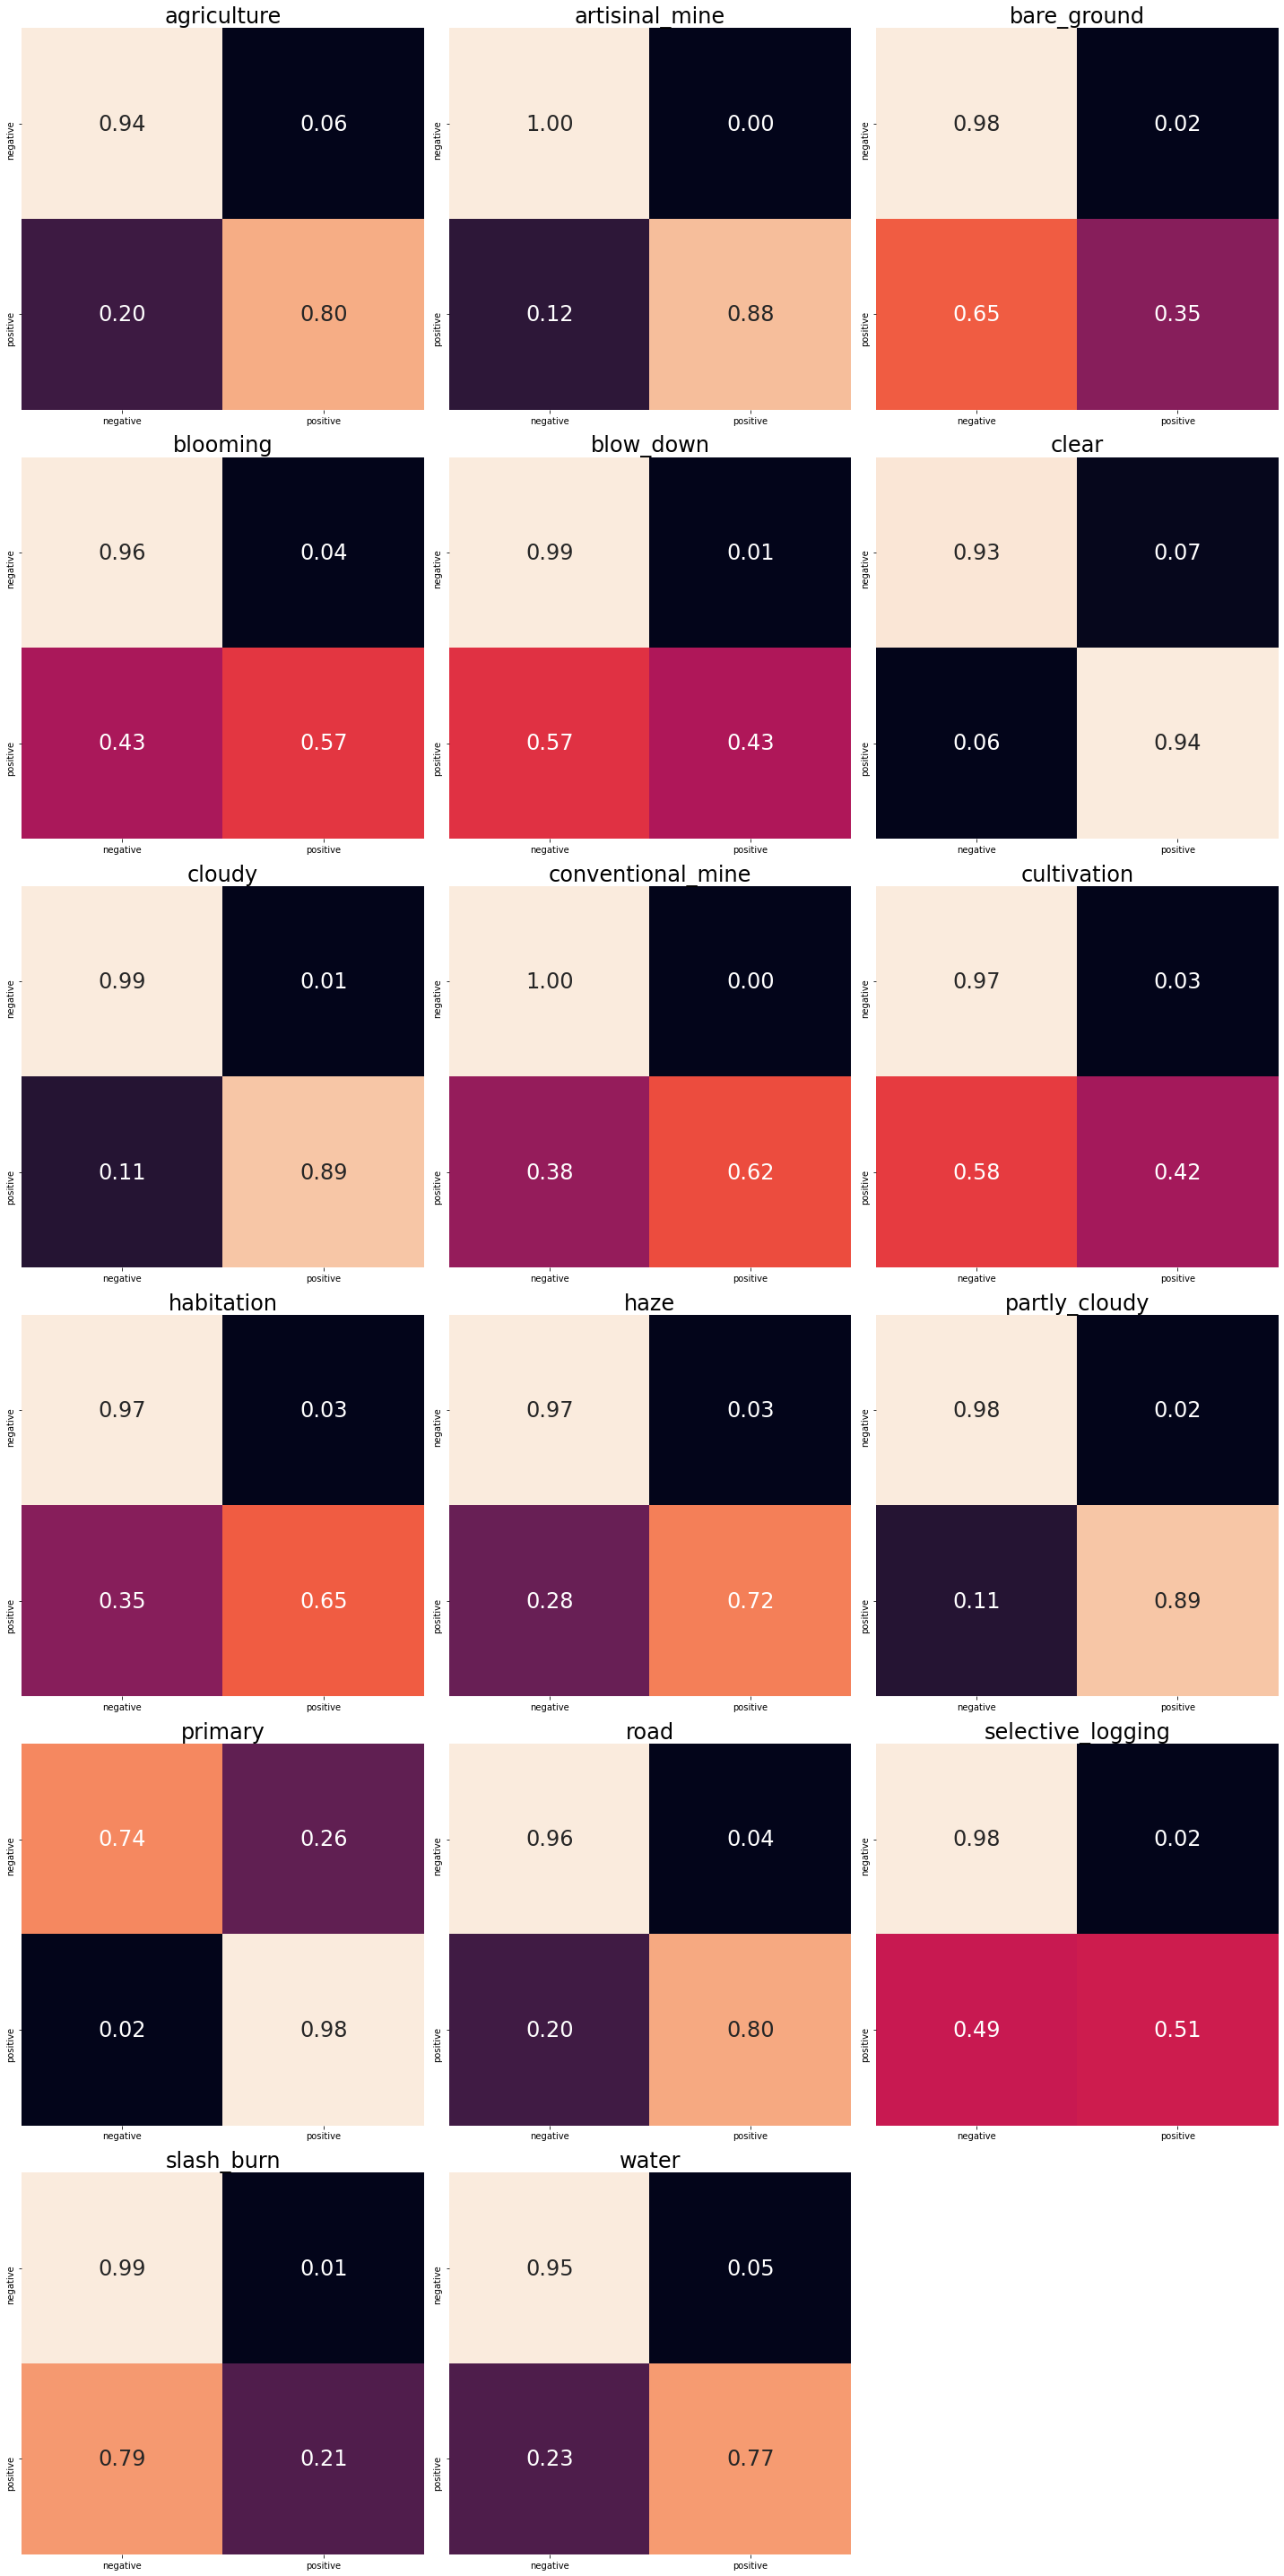

In [17]:
import numpy as np

# get true and predicted class labels
actual = np.asarray( df[ 'target' ].to_list() )
predict = getPrediction( df, model, stats )

# compute and plot multilabel confusion matrices
cms = getConfusionMatrices( actual, predict )
plotConfusionMatrices( cms, sum(actual[ :, 0:17]), 'test' ) 